In [1]:
import re, time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.8.0


In [ ]:
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy()
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

MIXED_PRECISION = True
if MIXED_PRECISION:
    if tpu: 
        policy = tf.keras.mixed_precision.Policy('mixed_bfloat16')
        tf.config.optimizer.set_jit(True)
    else: #
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.set_global_policy(policy)
    print('Mixed precision enabled')

In [24]:
EPOCHS = 10
IMAGE_SIZE = [224, 224]

FLOWERS_DATASETS = { # available image sizes
    192: 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec',
    224: 'gs://flowers-public/tfrecords-jpeg-224x224/*.tfrec',
    331: 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec',
    512: 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec'
}
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)
assert IMAGE_SIZE[0] == IMAGE_SIZE[1], "only square images are supported"
assert IMAGE_SIZE[0] in FLOWERS_DATASETS, "this image size is not supported"

In [5]:
# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync * 2
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync * 2
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync * 2
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync * 2
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

1e-05 0.00011223616000000004


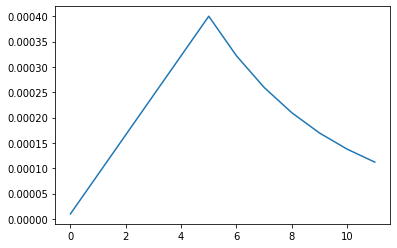

In [7]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [25]:
gcs_pattern = FLOWERS_DATASETS[IMAGE_SIZE[0]]
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
TRAIN_FILENAMES = filenames[:split]
VALID_FILENAMES = filenames[split:]
TRAIN_STEPS = count_data_items(TRAIN_FILENAMES) // BATCH_SIZE
print("TRAINING IMAGES: ", count_data_items(TRAIN_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALID_FILENAMES))

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  11
VALIDATION IMAGES:  680



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10
186/186 [==============================] - 56s 303ms/step - loss: 1.4872 - accuracy: 0.3589 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/10
186/186 [==============================] - 3s 15ms/step - loss: 1.0035 - accuracy: 0.6391 - lr: 8.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.000166.
Epoch 3/10
186/186 [==============================] - 3s 15ms/step - loss: 0.7973 - accuracy: 0.7298 - lr: 1.6600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000244.
Epoch 4/10
186/186 [==============================] - 3s 15ms/step - loss: 0.6376 - accuracy: 0.7782 - lr: 2.4400e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.000322.
Epoch 5/10
186/186 [==============================] - 3s 15ms/step - loss: 0.4946 - accuracy: 0.8293 - lr: 3.2200e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0004.
Epoch 6/10
1

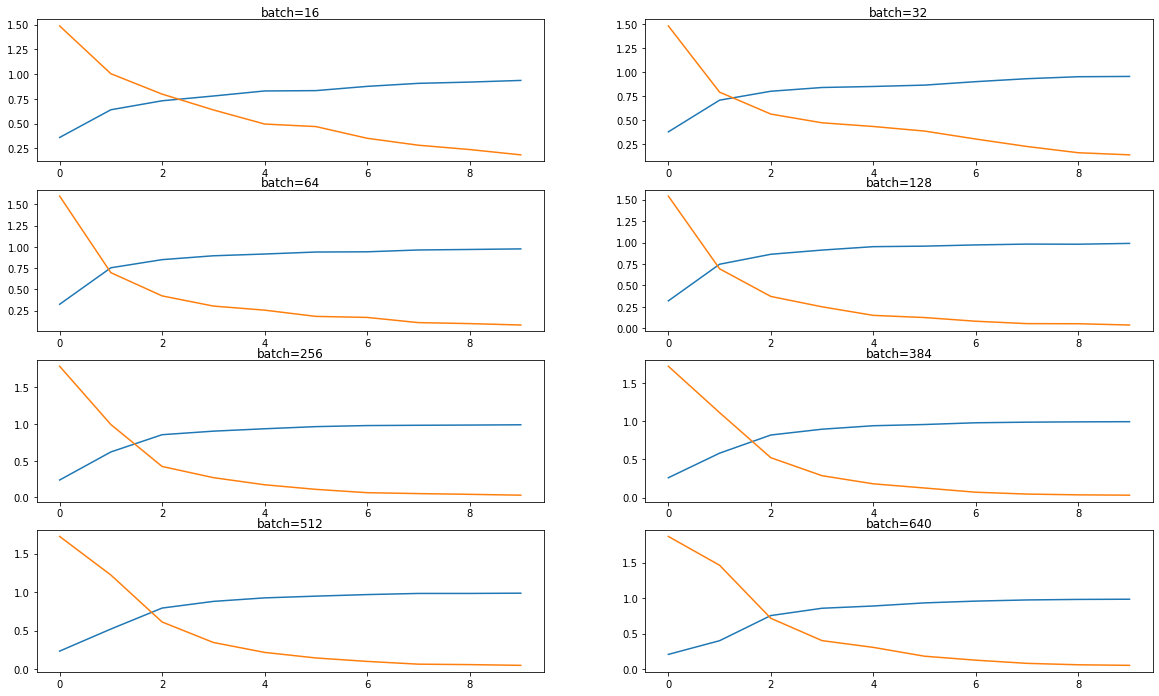

In [27]:
import pandas as pd
from functions import *
batch_size = [16*strategy.num_replicas_in_sync*x for x in range(1, 9)]
seconds = []
accuracy = []
loss = []
val_loss = []
val_acc = []

plt.subplots(4, 2, figsize=(20, 12))

plot_batches(batch_size, epochs=10)
plt.show()

In [29]:
df.to_csv('TPU_mobilenetv2.csv', index=False)